# Coding: Machine Translation by RNN

 - Dataset: wmt-17, en-zh, select 5m high-quality pairs of data
 - Model: Seq2seq with Encoder & Decoder framework
 - GPU: 1660TI

# Seq2Seq Encoder-Decoder Architecture

## Overview

The Sequence-to-Sequence (Seq2Seq) model with Encoder-Decoder architecture is a neural network framework designed for tasks where both input and output are sequences of variable length, such as machine translation (English → Chinese in your case).

```
Input Sequence (English):  "Hello world"
                              ↓
                          [ENCODER]
                              ↓
                        Context Vector
                              ↓
                          [DECODER]
                              ↓
Output Sequence (Chinese): "你好世界"
```

## Architecture Components

### 1. Encoder

The encoder processes the input sequence and compresses the information into a fixed-size context vector (also called thought vector).

```
Input: [w1, w2, w3, ..., wn]
       ↓    ↓    ↓       ↓
    [RNN][RNN][RNN]...[RNN]
       ↓    ↓    ↓       ↓
    [h1] [h2] [h3] ... [hn] → Context Vector (hn)
```

#### Key Components:
- **Embedding Layer**: Converts input tokens to dense vectors
- **RNN Layers**: LSTM/GRU cells process the sequence sequentially
- **Hidden States**: Capture information at each time step
- **Final Context**: Last hidden state becomes the context vector

```python
# Pseudo-code structure
class Encoder:
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)
        outputs, hidden = self.rnn(embedded)
        return hidden  # Context vectors
```

### 2. Decoder

The decoder generates the output sequence one token at a time, using the context vector from the encoder.

```
Context Vector (C) → [RNN] → [RNN] → [RNN] → ... → [RNN]
                      ↓       ↓       ↓             ↓
                    [y1]    [y2]    [y3]   ...   [yn]
```

#### Key Components:
- **Initial State**: Initialized with encoder's context vector
- **RNN Layers**: Generate hidden states for each output position
- **Output Projection**: Maps hidden states to vocabulary probabilities
- **Softmax**: Converts logits to probability distribution

```python
# Pseudo-code structure
class Decoder:
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers)
        self.output_projection = nn.Linear(hidden_size, vocab_size)

    def forward(self, target_seq, encoder_hidden, encoder_cell):
        embedded = self.embedding(target_seq)
        outputs, _ = self.rnn(embedded, encoder_hidden)
        predictions = self.output_projection(outputs)
        return predictions
```

## Complete Architecture Flow

### Training Phase

```
1. Input Processing:
   English: "Hello world" → [101, 7592, 2088, 102] (tokenized)
   Chinese: "[BOS] 你好世界 [EOS]" → [101, 872, 1962, 686, 102] (tokenized)

2. Encoder Forward Pass:
   Input: [101, 7592, 2088, 102]
   ↓
   Embedding: [[0.1, 0.2, ...], [0.3, 0.4, ...], ...]
   ↓
   LSTM/GRU: h1, h2, h3, h4 → Context Vector (h4)

3. Decoder Forward Pass:
   Initial State: (h4) from encoder
   Input: [101, 872, 1962, 686]
   ↓
   LSTM/GRU: generates hidden states for each position
   ↓
   Output Projection: [vocab_size] logits for each position
   ↓
   Loss Calculation: CrossEntropy with targets [872, 1962, 686, 102]
```

### Inference Phase

```
1. Encode input sequence: "Hello world"
2. Initialize decoder with encoder's context vector
3. Start with [BOS] token
4. Generate tokens one by one:
   - Input: [BOS] → Output: 你 (probability distribution)
   - Input: [BOS] 你 → Output: 好
   - Input: [BOS] 你 好 → Output: 世
   - Input: [BOS] 你 好 世 → Output: 界
   - Input: [BOS] 你 好 世 界 → Output: [EOS] (stop)
```

## Mathematical Formulation

### Encoder
```
h_t = LSTM/GRU(embedding(x_t), h_{t-1})
context = h_n  # Final hidden state
```

### Decoder
```
s_t = LSTM/GRU(embedding(y_{t-1}), s_{t-1})  # s_0 = context
P(y_t | y_1...y_{t-1}, x) = softmax(W_s * s_t + b_s)
```

### Loss Function
```
Loss = -∑∑ log P(y_t^i | y_1^i...y_{t-1}^i, x^i)
```

## Architecture Advantages

1. **Variable Length Handling**: Can process sequences of different lengths
2. **End-to-End Learning**: Jointly optimizes encoder and decoder
3. **Context Preservation**: Encoder captures semantic meaning in context vector
4. **Language Agnostic**: Works for any language pair

## Architecture Limitations

1. **Information Bottleneck**: Fixed-size context vector may lose information
2. **Long Sequence Problem**: Difficulty with very long input sequences
3. **Sequential Processing**: Cannot parallelize during inference

## Improvements & Variants

1. **Attention Mechanism**: Allows decoder to focus on relevant encoder states
2. **Bidirectional Encoder**: Processes sequence in both directions
3. **Beam Search**: Better decoding strategy than greedy search
4. **Teacher Forcing**: Training technique using ground truth as decoder input

## Implementation Architecture for Your Project

Based on your dataset (WMT-17 EN-ZH) and tokenizers (BERT-based), here's the recommended architecture:

```
Input: English sentence (max_length=100)
↓
BERT Tokenizer (vocab_size=30522) → Token IDs
↓
Embedding Layer (30522 → 512)
↓
Encoder LSTM/GRU (512 → 1024, num_layers=2)
↓
Context Vector (1024-dim)
↓
Decoder LSTM/GRU (512 → 1024, num_layers=2)
↓
Output Projection (1024 → 21128)
↓
Chinese Token IDs → BERT Tokenizer → Chinese sentence
```

In [1]:
# 可以先测试网络连接
import requests
try:
    response = requests.get("https://huggingface.co")
    print("网络连接正常")
except:
    print("网络连接可能存在问题")

网络连接正常


In [2]:
# Download the data & select 5m high-quality pairs

from datasets import load_dataset
import re

# load full wmt-17 en-zh dataset
full_dataset = load_dataset("wmt/wmt17", "zh-en", split="train", cache_dir=r"D:\Developer\LLM\FuggingFace-cache-model")

# Length & Ratio filter
def is_high_quality(x):
    import re  # 添加这一行
    en = x["translation"]["en"]
    zh = x["translation"]["zh"]
    if not en or not zh:
        return False
    if len(en) < 3 or len(zh) < 3:
        return False
    if len(en) > 100 or len(zh) > 100:
        return False
    ratio = len(en) / len(zh)
    if ratio < 0.5 or ratio > 2:
        return False
    if not re.search(r'[\u4e00-\u9fff]', zh):
        return False
    return True

filtered_dataset = full_dataset.filter(is_high_quality, num_proc=10)
dataset = filtered_dataset.select(range(min(5_000_000, len(filtered_dataset))))     # 调整数据集大小：100_000, 5_000_000, 10_000_000, 20_000_000, 30_000_000, 40_000_000, 50_000_000

print("Full Dataset Size: ", len(full_dataset))
print("Filtered Dataset Size: ", len(filtered_dataset))
print("Dataset Size: ", len(dataset))

# print 10 samples
sample = dataset.shuffle(seed=42).select(range(10))
print("-"*100)
for i in sample:
    print(i["translation"]["en"])
    print(i["translation"]["zh"])
    print("-"*100)


Full Dataset Size:  25134743
Filtered Dataset Size:  1141860
Dataset Size:  1141860
----------------------------------------------------------------------------------------------------
Zambia (7)
赞比亚(7)
----------------------------------------------------------------------------------------------------
15:00 to 18:00 Informal consultations (closed) Conference Room 5 (NLB)
下午3:00－6:00 非正式磋商(闭门会议) 第5会议室(北草坪会议大楼)
----------------------------------------------------------------------------------------------------
Spain
西班牙
----------------------------------------------------------------------------------------------------
Mr. Robert Morrison
Robert Morrison先生 加拿大自然资源部
----------------------------------------------------------------------------------------------------
This satisfied the kids, but not the husband.
"孩子们得到了满意的答案, 但她的丈夫却没有。
----------------------------------------------------------------------------------------------------
Shutaro Omura (Japan)
Shutaro Omura（日本）
---------------

In [3]:
# Create PyTorch Dataset and DataLoader for training

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

# 自定义数据集（对原始数据集进行自定义处理，进行tokenizer）
class TranslationDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer_en, tokenizer_zh, max_length=100):
        """
        PyTorch Dataset wrapper for HuggingFace translation dataset

        Args:
            hf_dataset: HuggingFace dataset with translation pairs
            tokenizer_en: English tokenizer (optional, can be added later)
            tokenizer_zh: Chinese tokenizer (optional, can be added later)
            max_length: Maximum sequence length
        """
        self.dataset = hf_dataset
        self.tokenizer_en = tokenizer_en
        self.tokenizer_zh = tokenizer_zh
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        en_text = item["translation"]["en"]
        zh_text = item["translation"]["zh"]

        en_tokens = self.tokenizer_en(en_text,
                                        max_length=self.max_length,
                                        padding='max_length',
                                        truncation=True,
                                        return_tensors='pt')

        zh_tokens = self.tokenizer_zh(zh_text,
                                        max_length=self.max_length,
                                        padding='max_length',
                                        truncation=True,
                                        return_tensors='pt')

        return {
                'source_ids': en_tokens['input_ids'].squeeze(),     # 去除张量的多余维度，输出以为数字数组
                'target_ids': zh_tokens['input_ids'].squeeze(),
                'source_text': en_text,
                'target_text': zh_text
        }

# 制作训练数据集Loader和验证数据集Loader
def create_dataloaders(dataset, batch_size=64, num_workers=0, train_split=0.95):
    """
    Create train and validation DataLoaders from HuggingFace dataset

    Args:
        dataset: HuggingFace dataset with translation pairs
        batch_size: Batch size for DataLoaders
        num_workers: Number of worker processes for data loading
        train_split: Fraction of data to use for training

    Returns:
        train_dataloader, val_dataloader, train_dataset, val_dataset
    """

    # Split dataset into train and validation
    train_size = int(train_split * len(dataset))

    # Create indices for splitting
    indices = list(range(len(dataset)))
    train_indices, val_indices = train_test_split(indices,
                                                train_size=train_size,
                                                random_state=42)

    # Create train and validation datasets
    train_dataset_hf = dataset.select(train_indices)
    val_dataset_hf = dataset.select(val_indices)

    # tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
    tokenizer_en = AutoTokenizer.from_pretrained("bert-base-uncased")
    tokenizer_zh = AutoTokenizer.from_pretrained("bert-base-chinese")

    # get vocab sizes
    vocab_size_en = tokenizer_en.vocab_size
    vocab_size_zh = tokenizer_zh.vocab_size

    print(f"Vocab size for en: {vocab_size_en}")
    print(f"Vocab size for zh: {vocab_size_zh}")

    # Create PyTorch datasets
    train_dataset = TranslationDataset(train_dataset_hf, tokenizer_en, tokenizer_zh)
    val_dataset = TranslationDataset(val_dataset_hf, tokenizer_en, tokenizer_zh)

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")

    # Create DataLoaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        # pin_memory=True if torch.cuda.is_available() else False
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        # pin_memory=True if torch.cuda.is_available() else False
    )

    print(f"Train DataLoader: {len(train_dataloader)} batches")
    print(f"Validation DataLoader: {len(val_dataloader)} batches")

    return train_dataloader, val_dataloader, vocab_size_en, vocab_size_zh

def test_dataloader(dataloader):
    """Test the DataLoader by printing a sample batch"""
    print("\n" + "="*50)
    print("Sample batch from DataLoader:")
    print("="*50)

    # for batch in dataloader:
    #     print(f"Batch size: {len(batch['source_text'])}")
    #     print(f"Source example: {batch['source_text'][0]}")
    #     print(f"Source tokens: {batch['source_ids'][0]}")
    #     print(f"Target example: {batch['target_text'][0]}")
    #     print(f"Target tokens: {batch['target_ids'][0]}")
    #     break

    # 使用next和iter更直接地获取一个batch
    try:
        batch = next(iter(dataloader))
        print(f"Batch size: {len(batch['source_text'])}")
        print(f"Source example: {batch['source_text'][0]}")
        print(f"Source tokens shape: {batch['source_ids'][0].shape}")
        print(f"Target example: {batch['target_text'][0]}")
        print(f"Target tokens shape: {batch['target_ids'][0].shape}")
    except Exception as e:
        print(f"Error getting batch: {e}")

train_dataloader, val_dataloader, encoder_vocab_size, decoder_vocab_size = create_dataloaders(dataset)
test_dataloader(train_dataloader)
test_dataloader(val_dataloader)

Vocab size for en: 30522
Vocab size for zh: 21128
Train dataset size: 1084767
Validation dataset size: 57093
Train DataLoader: 16950 batches
Validation DataLoader: 893 batches

Sample batch from DataLoader:
Batch size: 64
Source example: Subtotal 484 400
Source tokens shape: torch.Size([100])
Target example: 小计 484,400
Target tokens shape: torch.Size([100])

Sample batch from DataLoader:
Batch size: 64
Source example: 74 and A/60/640/Add.1, para. 6
Source tokens shape: torch.Size([100])
Target example: (A/60/640/Add.1，第6段)
Target tokens shape: torch.Size([100])


In [4]:
# Define the Seq2Seq model with GRU

import torch
import torch.nn as nn

class Encoder(nn.Module):
    """
    Encoder component of the Seq2Seq model using GRU
    Processes the input sequence and generates context vectors
    """
    def __init__(self, vocab_size, embed_size=512, hidden_size=1024, num_layers=2, dropout=0.1):
        super(Encoder, self).__init__()

        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Embedding layer to convert token IDs to dense vectors
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)

        # GRU layer for processing sequences
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers,
                         batch_first=True, dropout=dropout, bidirectional=False)

    # 输入的是语句token序列（固定长度，制作数据集的时候已经处理成固定长度的token序列了），输出的是所有隐藏状态和最终隐藏状态
    def forward(self, input_seq):
        """
        Forward pass of the encoder

        Args:
            input_seq: Input token sequences [batch_size, seq_len]
            input_lengths: Actual lengths of sequences (for packed sequences)

        Returns:
            outputs: All hidden states [batch_size, seq_len, hidden_size]
            hidden: Final hidden state [num_layers, batch_size, hidden_size]
        """
        # Convert token IDs to embeddings
        embedded = self.embedding(input_seq)  # [batch_size, seq_len, embed_size]

        # Pass through GRU
        outputs, hidden = self.rnn(embedded)

        # outputs: [batch_size, seq_len, hidden_size]
        # hidden: [num_layers, batch_size, hidden_size]

        return outputs, hidden

class Decoder(nn.Module):
    """
    Decoder component of the Seq2Seq model using GRU
    Generates output sequence one token at a time
    """
    def __init__(self, vocab_size, embed_size=512, hidden_size=1024, num_layers=2, dropout=0.1):
        super(Decoder, self).__init__()

        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Embedding layer for target tokens
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)

        # GRU layer for generating sequences
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers,
                         batch_first=True, dropout=dropout, bidirectional=False)

        # Output projection layer to vocabulary
        self.output_projection = nn.Linear(hidden_size, vocab_size)

    # 输入一个单词，输出vocab_size大小的概率（最终去确定是哪个单词）
    def forward(self, input_token, hidden):
        """
        Forward pass of the decoder (single step)

        Args:
            input_token: Current input token [batch_size, 1]  输入为一个单词，输出也为一个单词
            hidden: Hidden state from encoder/previous step [num_layers, batch_size, hidden_size]

        Returns:
            output: Vocabulary predictions [batch_size, vocab_size]
            hidden: Updated hidden state [num_layers, batch_size, hidden_size]
        """
        # input_token: [batch_size, 1]
        embedded = self.embedding(input_token)  # [batch_size, 1, embed_size]

        # Pass through GRU
        gru_out, hidden = self.rnn(embedded, hidden)
        # gru_out: [batch_size, 1, hidden_size]
        # hidden: [num_layers, batch_size, hidden_size]

        # Project to vocabulary
        output = self.output_projection(gru_out.squeeze(1))  # [batch_size, hidden_size] -> [batch_size, vocab_size]

        # output: [batch_size, vocab_size]
        # hidden: [num_layers, batch_size, hidden_size]
        return output, hidden

    def forward_parallel(self, input_seq, hidden):
        """
        ⚡ NEW - Parallel forward for training (teacher forcing)
        Process entire sequence at once for 10-50x speedup during training
        """
        # input_sequence: [batch_size, seq_len]
        embedded = self.embedding(input_seq)  # [batch_size, seq_len, embed_size]

        # Process entire sequence in parallel,这里会进行优化，但是单词预测的时候还是会走单步预测，其他阶段会进行底层优化并行
        gru_out, final_hidden = self.rnn(embedded, hidden)
        # gru_out: [batch_size, seq_len, hidden_size]

        # Project to vocabulary for all timesteps
        outputs = self.output_projection(gru_out)  # [batch_size, seq_len, vocab_size]

        # outputs : [batch_size, seq_len, vocab_size]
        # final_hidden: [num_layers, batch_size, hidden_size]
        return outputs, final_hidden

class Seq2Seq(nn.Module):
    """
    Complete Sequence-to-Sequence model using GRU
    Combines Encoder and Decoder for translation
    """
    def __init__(self, encoder_vocab_size, decoder_vocab_size, embed_size=512,
                 hidden_size=1024, num_layers=2, dropout=0.1):
        super(Seq2Seq, self).__init__()

        self.encoder_vocab_size = encoder_vocab_size
        self.decoder_vocab_size = decoder_vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Initialize encoder and decoder
        self.encoder = Encoder(encoder_vocab_size, embed_size, hidden_size, num_layers, dropout)
        self.decoder = Decoder(decoder_vocab_size, embed_size, hidden_size, num_layers, dropout)

    # 根据输入的源序列和目标序列生成每个token的预测序列
    def forward(self, source_seq, target_seq):
        """
        ⚡ OPTIMIZED - Fast training forward with parallel processing
        Uses teacher forcing + parallel decoder processing
        """

        # hidden: [num_layers, batch_size, hidden_size]
        _, hidden = self.encoder(source_seq)

        # output: [batch_size, seq_len, vocab_size]
        outputs, _ = self.decoder.forward_parallel(target_seq, hidden)

        # output: [batch_size, seq_len, vocab_size]
        return outputs

    # 根据输入的源序列生成目标序列
    def generate(self, source_seq, max_length=100, start_token=101, end_token=102):
        """
        Generate translation for given source sequence (inference mode)

        Args:
            source_seq: Source sequence [batch_size, source_len]
            max_length: Maximum length of generated sequence
            start_token: BOS token ID (101 for BERT)
            end_token: EOS token ID (102 for BERT)

        Returns:
            generated_seq: Generated sequence [batch_size, generated_len]
        """
        self.eval()
        batch_size = source_seq.size(0)

        with torch.no_grad():
            # Encode source sequence
            _, hidden = self.encoder(source_seq)

            # Initialize with start token
            # decoder_input: [batch_size, 1]
            decoder_input = torch.full((batch_size, 1), start_token, dtype=torch.long).to(source_seq.device)

            # Store generated tokens
            generated_tokens = []

            for _ in range(max_length):
                # Get next token prediction
                # output: [batch_size, 1, vocab_size]
                output, hidden = self.decoder(decoder_input, hidden)

                # Get the token with highest probability
                # next_token: [batch_size, 1]
                next_token = output.argmax(dim=1).unsqueeze(1)
                # generated_tokens: [batch_size, i+1]
                generated_tokens.append(next_token)

                # Use predicted token as next input
                decoder_input = next_token

                # Stop if all sequences generated EOS token
                if torch.all(next_token.squeeze() == end_token):
                    break

            # Concatenate all generated tokens
            # generated_seq: [batch_size, 1],输出预测的序列
            generated_seq = torch.cat(generated_tokens, dim=1)

        return generated_seq

    # Model configuration based on your dataset
model_config = {
    'encoder_vocab_size': encoder_vocab_size,  # 30522 (English BERT)
    'decoder_vocab_size': decoder_vocab_size,  # 21128 (Chinese BERT)
    'embed_size': 64,      # embed_size: 64 → 96 → 128
    'hidden_size': 128,     # hidden_size: 128 → 192 → 256
    'num_layers': 2,        # num_layers: 1 → 2
    'dropout': 0.1
}

# Initialize the model
model = Seq2Seq(**model_config)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print("=== Seq2Seq Model with GRU Architecture ===")
print(f"Device: {device}")
print(f"Encoder Vocabulary Size: {model_config['encoder_vocab_size']:,}")
print(f"Decoder Vocabulary Size: {model_config['decoder_vocab_size']:,}")
print(f"Embedding Size: {model_config['embed_size']}")
print(f"Hidden Size: {model_config['hidden_size']}")
print(f"Number of Layers: {model_config['num_layers']}")
print(f"Dropout Rate: {model_config['dropout']}")
print(f"RNN Type: GRU (Gated Recurrent Unit)")

# Calculate total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Model Size: {total_params * 4 / 1024 / 1024:.2f} MB")

# Print model architecture
print(f"\n=== Model Architecture ===")
print(model)

# Test the model with a sample batch
print(f"\n=== Testing Model Forward Pass ===")
sample_batch = next(iter(train_dataloader))
source_ids = sample_batch['source_ids'].to(device)
target_ids = sample_batch['target_ids'].to(device)

print(f"Source shape: {source_ids.shape}")
print(f"Target shape: {target_ids.shape}")

# Forward pass
model.train()
outputs = model(source_ids, target_ids)
print(f"Output shape: {outputs.shape}")
print(f"Expected shape: [batch_size, target_len, decoder_vocab_size]")
print(f"Actual shape: [{outputs.shape[0]}, {outputs.shape[1]}, {outputs.shape[2]}]")        # [batch_size, seq_len, vocab_size]

# Test generation
print(f"\n=== Testing Model Generation ===")
model.eval()
with torch.no_grad():
    generated = model.generate(source_ids[:2], max_length=100)  # Generate for first 2 samples
    print(f"Generated sequence shape: {generated.shape}")
    print(f"Generated tokens (first sample): {generated[0].tolist()}")

=== Seq2Seq Model with GRU Architecture ===
Device: cuda
Encoder Vocabulary Size: 30,522
Decoder Vocabulary Size: 21,128
Embedding Size: 64
Hidden Size: 128
Number of Layers: 2
Dropout Rate: 0.1
RNN Type: GRU (Gated Recurrent Unit)

Total Parameters: 6,378,248
Trainable Parameters: 6,378,248
Model Size: 24.33 MB

=== Model Architecture ===
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(30522, 64, padding_idx=0)
    (rnn): GRU(64, 128, num_layers=2, batch_first=True, dropout=0.1)
  )
  (decoder): Decoder(
    (embedding): Embedding(21128, 64, padding_idx=0)
    (rnn): GRU(64, 128, num_layers=2, batch_first=True, dropout=0.1)
    (output_projection): Linear(in_features=128, out_features=21128, bias=True)
  )
)

=== Testing Model Forward Pass ===
Source shape: torch.Size([64, 100])
Target shape: torch.Size([64, 100])
Output shape: torch.Size([64, 100, 21128])
Expected shape: [batch_size, target_len, decoder_vocab_size]
Actual shape: [64, 100, 21128]

=== Testing Model Generatio

Starting training...
=== Starting Training for 10 Epochs ===
Device: cuda
Train batches: 16950
Validation batches: 893
Model parameters: 6,378,248

Epoch 1/10
----------------------------------------


Train Loss: 3.4909
Val Loss: 2.7440
Learning Rate: 0.000500
Epoch Time: 1702.06s
New best validation loss: 2.7440
Model saved to best_seq2seq_model.pth

Epoch 2/10
----------------------------------------


Train Loss: 2.6314
Val Loss: 2.4356
Learning Rate: 0.000500
Epoch Time: 1593.38s
New best validation loss: 2.4356
Model saved to best_seq2seq_model.pth

Epoch 3/10
----------------------------------------


Train Loss: 2.4159
Val Loss: 2.2864
Learning Rate: 0.000500
Epoch Time: 1590.30s
New best validation loss: 2.2864
Model saved to best_seq2seq_model.pth

Epoch 4/10
----------------------------------------


Train Loss: 2.2947
Val Loss: 2.1957
Learning Rate: 0.000500
Epoch Time: 1591.03s
New best validation loss: 2.1957
Model saved to best_seq2seq_model.pth

Epoch 5/10
----------------------------------------


Train Loss: 2.2185
Val Loss: 2.1359
Learning Rate: 0.000500
Epoch Time: 1578.61s
New best validation loss: 2.1359
Model saved to best_seq2seq_model.pth

Epoch 6/10
----------------------------------------


Train Loss: 2.1646
Val Loss: 2.0919
Learning Rate: 0.000500
Epoch Time: 1571.39s
New best validation loss: 2.0919
Model saved to best_seq2seq_model.pth

Epoch 7/10
----------------------------------------


Train Loss: 2.1245
Val Loss: 2.0590
Learning Rate: 0.000500
Epoch Time: 1574.53s
New best validation loss: 2.0590
Model saved to best_seq2seq_model.pth

Epoch 8/10
----------------------------------------


Train Loss: 2.0935
Val Loss: 2.0356
Learning Rate: 0.000500
Epoch Time: 1572.44s
New best validation loss: 2.0356
Model saved to best_seq2seq_model.pth

Epoch 9/10
----------------------------------------


Train Loss: 2.0694
Val Loss: 2.0161
Learning Rate: 0.000500
Epoch Time: 1576.90s
New best validation loss: 2.0161
Model saved to best_seq2seq_model.pth

Epoch 10/10
----------------------------------------


Train Loss: 2.0494
Val Loss: 1.9974
Learning Rate: 0.000500
Epoch Time: 1576.74s
New best validation loss: 1.9974
Model saved to best_seq2seq_model.pth

Training completed in 15928.31s (265.47 min)
Best validation loss: 1.9974
Final train loss: 2.0494
Final val loss: 1.9974

Plotting training history...


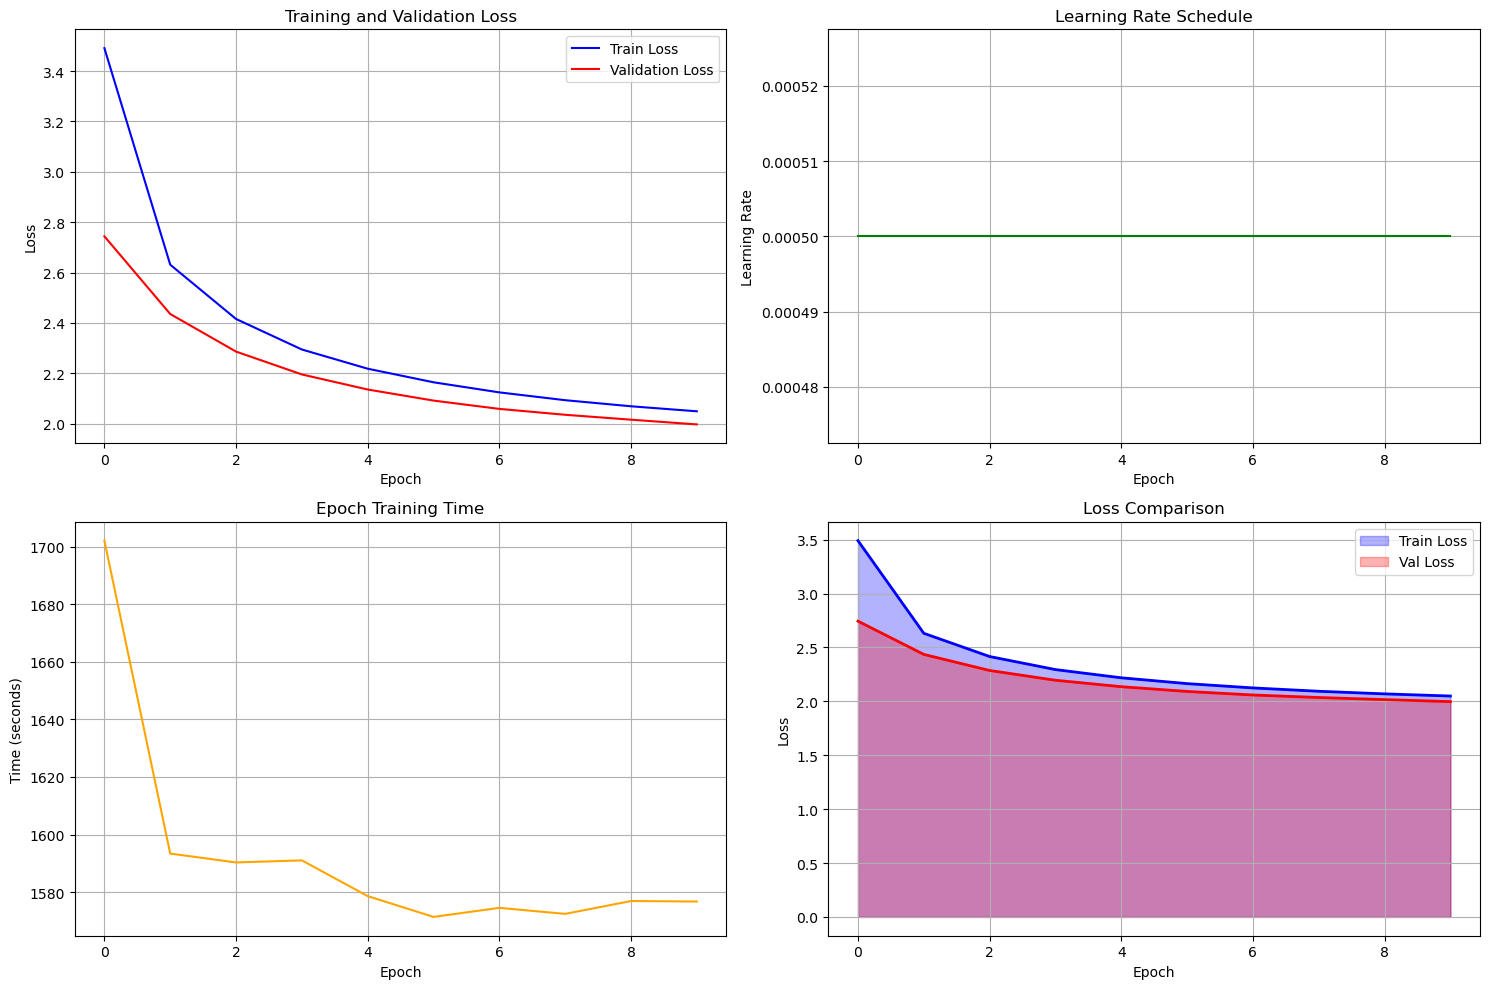

In [5]:
# Train the model with comprehensive training loop

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from collections import defaultdict

class Trainer:
    """
    Trainer class for Seq2Seq machine translation model
    """
    def __init__(self, model, train_dataloader, val_dataloader, device,
                 learning_rate=1e-3, weight_decay=1e-5):
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.device = device

        # Loss function - ignore padding tokens (index 0)，忽略填充值（索引为0）的损失计算，对所有元素取平均
        self.criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='mean')

        # Optimizer
        """
        # 标准梯度下降更新公式：
        # w_new = w_old - learning_rate * gradient

        # 使用 weight_decay (weight_decay=1e-5)
        # 带L2正则化的梯度下降更新公式：
        w_new = w_old - learning_rate * (gradient + weight_decay * w_old)

        w大的会减少的更多
        weight_decay 通过在每次更新时添加一个与权重大小成正比的衰减项，以及一个乘法衰减因子，有效地防止了权重变得过大，从而约束权重在合理范围内。
        """
        self.optimizer = optim.Adam(model.parameters(),
                                  lr=learning_rate,
                                  weight_decay=weight_decay)

        # Learning rate scheduler，当监测指标停止改善时降低学习率
        # mode='min' 的工作逻辑：
        # 1. 持续监测验证损失
        # 2. 如果验证损失连续 'patience' 个epoch没有减少
        # 3. 则将学习率乘以 'factor' (通常是减小学习率)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            # mode='min'：监测指标越小越好
            # factor=0.5：每次学习率减少时，将学习率乘以0.5
            # patience=2：patience为2，表示在2个epoch内没有改善时，学习率将减少
            self.optimizer, mode='min', factor=0.5, patience=2,
        )

        # Training history，创建训练历史记录字典，用于存储训练过程中的各种指标
        self.history = defaultdict(list)

    def calculate_loss(self, outputs, targets, target_lengths=None):
        """Calculate loss for the batch"""
        # Reshape for loss calculation (use reshape instead of view for non-contiguous tensors)
        # outputs_flat：将输出从 [batch_size, seq_len, vocab_size] 变为 [batch_size*seq_len, vocab_size]
        outputs_flat = outputs.reshape(-1, outputs.size(-1))
        # targets_flat：将目标从 [batch_size, seq_len] 变为 [batch_size*seq_len]
        targets_flat = targets.reshape(-1)

        # Calculate loss
        # loss: [batch_size*seq_len]
        loss = self.criterion(outputs_flat, targets_flat)

        return loss

    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        epoch_loss = 0.0
        num_batches = 0

        progress_bar = tqdm(self.train_dataloader, desc="Training", leave=False)

        # Loop over batches
        for batch_idx, batch in enumerate(progress_bar):
            # Move batch to device
            source_ids = batch['source_ids'].to(self.device)
            target_ids = batch['target_ids'].to(self.device)

            # Zero gradients
            self.optimizer.zero_grad()

            # Forward pass with teacher forcing
            decoder_input = target_ids[:, :-1]  # Remove last token
            decoder_targets = target_ids[:, 1:]  # Remove first token (BOS)

            # outputs: [batch_size, seq_len, vocab_size]
            outputs = self.model(source_ids, decoder_input)

            # Calculate loss
            loss = self.calculate_loss(outputs, decoder_targets)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            # Update parameters
            self.optimizer.step()

            # Update metrics
            epoch_loss += loss.item()
            num_batches += 1

            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Avg Loss': f'{epoch_loss / num_batches:.4f}'
            })

            # Memory cleanup
            if batch_idx % 100 == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()

        return epoch_loss / num_batches

    def validate_epoch(self):
        """Validate for one epoch"""
        self.model.eval()
        epoch_loss = 0.0
        num_batches = 0

        progress_bar = tqdm(self.val_dataloader, desc="Validation", leave=False)

        with torch.no_grad():
            for batch in progress_bar:
                # Move batch to device
                source_ids = batch['source_ids'].to(self.device)
                target_ids = batch['target_ids'].to(self.device)

                # Forward pass
                decoder_input = target_ids[:, :-1]
                decoder_targets = target_ids[:, 1:]

                # outputs: [batch_size, seq_len, vocab_size]
                outputs = self.model(source_ids, decoder_input)

                # Calculate loss
                # loss: [batch_size*seq_len]
                loss = self.calculate_loss(outputs, decoder_targets)

                # Update metrics
                epoch_loss += loss.item()
                num_batches += 1

                # Update progress bar
                progress_bar.set_postfix({
                    'Val Loss': f'{loss.item():.4f}',
                    'Avg Val Loss': f'{epoch_loss / num_batches:.4f}'
                })

        return epoch_loss / num_batches

    def train(self, num_epochs=10, save_path=None):
        """Train the model for specified number of epochs"""
        print(f"=== Starting Training for {num_epochs} Epochs ===")
        print(f"Device: {self.device}")
        print(f"Train batches: {len(self.train_dataloader)}")
        print(f"Validation batches: {len(self.val_dataloader)}")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print("=" * 60)

        best_val_loss = float('inf')
        start_time = time.time()

        for epoch in range(num_epochs):
            epoch_start_time = time.time()

            print(f"\nEpoch {epoch + 1}/{num_epochs}")
            print("-" * 40)

            # Train
            train_loss = self.train_epoch()

            # Validate
            val_loss = self.validate_epoch()

            # Update learning rate scheduler
            self.scheduler.step(val_loss)

            # Calculate epoch time
            epoch_time = time.time() - epoch_start_time

            # Store history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['epoch_time'].append(epoch_time)
            self.history['learning_rate'].append(self.optimizer.param_groups[0]['lr'])

            # Print epoch summary
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}")
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}")
            print(f"Epoch Time: {epoch_time:.2f}s")

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                print(f"New best validation loss: {best_val_loss:.4f}")

                if save_path:
                    torch.save({
                        'epoch': epoch + 1,
                        'model_state_dict': self.model.state_dict(),
                        'optimizer_state_dict': self.optimizer.state_dict(),
                        'train_loss': train_loss,
                        'val_loss': val_loss,
                        'model_config': model_config
                    }, save_path)
                    print(f"Model saved to {save_path}")

            # Memory cleanup
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        # Training summary
        total_time = time.time() - start_time
        print(f"\n{'='*60}")
        print(f"Training completed in {total_time:.2f}s ({total_time/60:.2f} min)")
        print(f"Best validation loss: {best_val_loss:.4f}")
        print(f"Final train loss: {self.history['train_loss'][-1]:.4f}")
        print(f"Final val loss: {self.history['val_loss'][-1]:.4f}")

        return self.history

    def plot_training_history(self):
        """Plot training history"""
        if not self.history['train_loss']:
            print("No training history to plot")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Plot loss
        axes[0, 0].plot(self.history['train_loss'], label='Train Loss', color='blue')
        axes[0, 0].plot(self.history['val_loss'], label='Validation Loss', color='red')
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Plot learning rate
        axes[0, 1].plot(self.history['learning_rate'], color='green')
        axes[0, 1].set_title('Learning Rate Schedule')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Learning Rate')
        axes[0, 1].grid(True)

        # Plot epoch time
        axes[1, 0].plot(self.history['epoch_time'], color='orange')
        axes[1, 0].set_title('Epoch Training Time')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Time (seconds)')
        axes[1, 0].grid(True)

        # Plot loss comparison
        x = range(len(self.history['train_loss']))
        axes[1, 1].fill_between(x, self.history['train_loss'], alpha=0.3, color='blue', label='Train Loss')
        axes[1, 1].fill_between(x, self.history['val_loss'], alpha=0.3, color='red', label='Val Loss')
        axes[1, 1].plot(self.history['train_loss'], color='blue', linewidth=2)
        axes[1, 1].plot(self.history['val_loss'], color='red', linewidth=2)
        axes[1, 1].set_title('Loss Comparison')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        plt.tight_layout()
        plt.show()

# Initialize trainer
trainer = Trainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    learning_rate=0.001,
    weight_decay=1e-5
)

# Start training for 10 epochs
print("Starting training...")
history = trainer.train(num_epochs=10, save_path="best_seq2seq_model.pth")

# Plot training history
print("\nPlotting training history...")
trainer.plot_training_history()

In [9]:
# Comprehensive Machine Translation Testing Code

import torch
import torch.nn.functional as F
from transformers import AutoTokenizer
import numpy as np
from collections import Counter
import re
import time
import math

class TranslationTester:
    """
    Comprehensive tester for the Seq2Seq machine translation model
    """
    def __init__(self, model, device, max_length=100):
        self.model = model
        self.device = device
        self.max_length = max_length

        # Load tokenizers，加载英文和中文的BERT分词器
        self.tokenizer_en = AutoTokenizer.from_pretrained("bert-base-uncased")
        self.tokenizer_zh = AutoTokenizer.from_pretrained("bert-base-chinese")

        # Special tokens
        self.start_token = 101  # [BOS] token，开始标记
        self.end_token = 102   # [EOS] token，结束标记
        self.pad_token = 0     # [PAD] token，填充标记

        print("=== Translation Tester Initialized ===")
        print(f"Device: {device}")
        print(f"English tokenizer vocab size: {self.tokenizer_en.vocab_size}")
        print(f"Chinese tokenizer vocab size: {self.tokenizer_zh.vocab_size}")
        print(f"Max sequence length: {max_length}")

    def preprocess_text(self, text):
        """Clean and preprocess input text"""
        # Basic cleaning
        text = text.strip()             # 去除首尾空格
        text = re.sub(r'\s+', ' ', text)  # Multiple spaces to single space，将多个空格替换为单个空格
        return text

    def encode_english(self, text):
        """Encode English text to token IDs"""
        text = self.preprocess_text(text)       # 先进行文本预处理
        tokens = self.tokenizer_en(
            text,
            max_length=self.max_length,     # 设置最大长度
            padding='max_length',               # 填充到最大长度
            truncation=True,                    # 超长则截断
            return_tensors='pt'             # 返回PyTorch张量
        )
        return tokens['input_ids'].to(self.device)          # 返回token ID并移到指定设备

    def decode_chinese(self, token_ids):
        """Decode Chinese token IDs to text"""
        # Remove padding tokens and special tokens
        if isinstance(token_ids, torch.Tensor):
            token_ids = token_ids.cpu().tolist()        # 如果是张量则转换为列表

        # Remove padding (0), start (101), and end (102) tokens，清理token，移除填充、开始和结束标记
        cleaned_tokens = []
        for token_id in token_ids:
            if token_id not in [0, 101, 102]:       # 不是特殊标记
                cleaned_tokens.append(token_id)
            elif token_id == 102:  # Stop at end token，遇到结束标记则停止
                break

        if not cleaned_tokens:
            return "[Empty translation]"        # 如果没有有效token，返回空翻译提示

        try:
            # 使用中文分词器解码
            text = self.tokenizer_zh.decode(cleaned_tokens, skip_special_tokens=True)
            # Clean up extra spaces
            text = re.sub(r'\s+', '', text)  # Remove all spaces for Chinese，移除所有空格（中文不需要空格）
            return text if text else "[Empty translation]"      # 返回解码文本或空翻译提示
        except Exception as e:
            return f"[Decoding error: {str(e)}]"        # 出错时返回错误信息

    def _beam_search_translate(self, source_ids, beam_size=3, temperature=1.0):
        """Simplified beam search implementation"""
        batch_size = source_ids.size(0)

        # Encode source
        _, hidden = self.model.encoder(source_ids)

        # Initialize beams，初始化束（序列，得分，隐藏状态）
        beams = [(torch.tensor([[self.start_token]]).to(self.device), 0.0, hidden)]

        # 逐个生成token
        for step in range(self.max_length):
            new_beams = []

            for seq, score, h in beams:
                # 如果序列已结束，直接添加到新束中
                if seq[0, -1].item() == self.end_token:
                    new_beams.append((seq, score, h))
                    continue

                # Get next token probabilities，获取下一个token的概率
                last_token = seq[:, -1:]    # 获取最后一个token
                output, new_h = self.model.decoder(last_token, h)   # 解码

                # Apply temperature，应用温度参数调整概率分布
                if temperature != 1.0:
                    output = output / temperature

                probs = F.softmax(output, dim=-1)       # 转换为概率

                # Get top k candidates，获取前k个候选
                top_probs, top_indices = torch.topk(probs, beam_size)

                # 为每个候选创建新序列
                for i in range(beam_size):
                    token_id = top_indices[0, i].unsqueeze(0).unsqueeze(0)
                    token_prob = top_probs[0, i].item()
                    new_seq = torch.cat([seq, token_id], dim=1)     # 连接新token
                    new_score = score + math.log(token_prob + 1e-10)    # 更新得分
                    new_beams.append((new_seq, new_score, new_h))

            # Keep only top beams   保留得分最高的束
            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_size]

            # Check if all beams ended  检查是否所有束都已结束
            if all(seq[0, -1].item() == self.end_token for seq, _, _ in beams):
                break

        # Return best beam  返回最佳翻译结果
        best_seq = beams[0][0]
        return self.decode_chinese(best_seq[0])

    def translate_single(self, english_text, beam_size=1, temperature=1.0):
        """
        Translate a single English sentence to Chinese 将单个英文句子翻译为中文

        Args:
            english_text: Input English text
            beam_size: Beam search size (1 for greedy)
            temperature: Sampling temperature for generation
        """
        self.model.eval()

        with torch.no_grad():
            # Encode input
            # source_ids: Tensor of shape (1, seq_len)
            source_ids = self.encode_english(english_text)

            if beam_size == 1:
                # Greedy decoding 贪婪解码
                # generated: Tensor of shape (1, seq_len)
                generated = self.model.generate(
                    source_ids,
                    max_length=self.max_length,
                    start_token=self.start_token,
                    end_token=self.end_token
                )
                translation = self.decode_chinese(generated[0])
            else:
                # Beam search (simplified version) 束搜索解码
                translation = self._beam_search_translate(source_ids, beam_size, temperature)

        return translation

    """
    BLEU（Bilingual Evaluation Understudy）评分是一种用于评估机器翻译质量的自动评估指标

    BLEU评分的基本原理
    BLEU评分通过比较机器翻译结果与一个或多个参考翻译之间的相似度来评估翻译质量。

    1. N-gram精度匹配
        BLEU的核心思想是计算翻译结果中n-gram（连续的n个词）与参考翻译中n-gram的匹配程度：
            1-gram: 单个词的匹配
            2-gram: 连续两个词的匹配
            3-gram: 连续三个词的匹配
            4-gram: 连续四个词的匹配
    2. 精度计算
        对于每种n-gram，计算精度（precision）：
            精度 = 匹配的n-gram数量 / 翻译结果中的n-gram总数
    3. 几何平均
        BLEU将1-gram到4-gram的精度进行几何平均
    4. 长度惩罚（Brevity Penalty, BP）
        为了避免过短的翻译获得高分，BLEU引入了长度惩罚
    5. 最终BLEU计算
        BLEU = BP × 几何平均精度

    BLEU评分的特点
        优点：
            自动化: 不需要人工评估，计算快速
            标准化: 提供统一的评估标准
            相关性: 与人工评估结果有一定相关性
        缺点：
            无法评估语义: 只关注词汇匹配，不考虑语义正确性
            依赖参考翻译: 质量高度依赖参考翻译的质量和数量
            对创新表达不友好: 与参考翻译不同的正确表达可能得分较低

    假设我们有以下翻译示例：
        参考翻译（Reference）: "我爱学习"
        机器翻译结果（Candidate）: "我很爱学习"
    第一步：分词处理
        由于是中文，我们按字符进行分词：
        参考翻译tokens: ['我', '爱', '学', '习']
        候选翻译tokens: ['我', '很', '爱', '学', '习']
    第二步：计算N-gram精度
        1-gram（单字符）精度：
            参考翻译中的1-gram: {'我': 1, '爱': 1, '学': 1, '习': 1} 候选翻译中的1-gram: {'我': 1, '很': 1, '爱': 1, '学': 1, '习': 1}
            匹配的1-gram: min(1,1) + min(1,1) + min(1,1) + min(1,1) = 4 候选翻译中1-gram总数: 5 1-gram精度 = 4/5 = 0.8
        2-gram（双字符）精度：
            参考翻译中的2-gram: {('我','爱'): 1, ('爱','学'): 1, ('学','习'): 1} 候选翻译中的2-gram: {('我','很'): 1, ('很','爱'): 1, ('爱','学'): 1, ('学','习'): 1}
            匹配的2-gram: min(1,1) + min(1,1) = 2 （匹配了('爱','学')和('学','习')） 候选翻译中2-gram总数: 4 2-gram精度 = 2/4 = 0.5
        3-gram（三字符）精度：
            参考翻译中的3-gram: {('我','爱','学'): 1, ('爱','学','习'): 1} 候选翻译中的3-gram: {('我','很','爱'): 1, ('很','爱','学'): 1, ('爱','学','习'): 1}
            匹配的3-gram: min(1,1) = 1 （匹配了('爱','学','习')） 候选翻译中3-gram总数: 3 3-gram精度 = 1/3 ≈ 0.3333
        4-gram（四字符）精度：
            参考翻译中的4-gram: {('我','爱','学','习'): 1} 候选翻译中的4-gram: {('我','很','爱','学'): 1, ('很','爱','学','习'): 1}
            匹配的4-gram: 0 候选翻译中4-gram总数: 2 4-gram精度 = 0/2 = 0
    第三步：计算几何平均精度
        precision = [0.8, 0.5, 0.3333, 0.0] 几何平均 = (0.8 × 0.5 × 0.3333 × 0.0)^(1/4) = 0
        注意：由于有一个精度为0，几何平均为0。为了避免这个问题，实际计算中使用对数形式： 几何平均 = exp((ln(0.8) + ln(0.5) + ln(0.3333) + ln(0.0001))/4) （这里用0.0001代替0，因为ln(0)是未定义的）
    第四步：计算长度惩罚（Brevity Penalty）
        参考翻译长度: 4 候选翻译长度: 5
        因为候选翻译长度(5) > 参考翻译长度(4)，所以: BP = 1.0
    第五步：计算最终BLEU得分
        BLEU = BP × 几何平均精度 = 1.0 × 0 = 0
    """
    def calculate_bleu_score(self, reference, candidate):
        """
        Calculate BLEU score (simplified version) 计算BLEU评分（简化版本）
        """
        def get_ngrams(tokens, n):
            return [tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]

        # Tokenize (character-level for Chinese) 分词（中文使用字符级）
        ref_tokens = list(reference.replace(' ', ''))
        cand_tokens = list(candidate.replace(' ', ''))

        if len(cand_tokens) == 0:
            return 0.0

        # Calculate precision for n-grams (1 to 4) 计算1-4 gram的精度
        precisions = []
        for n in range(1, 5):
            ref_ngrams = Counter(get_ngrams(ref_tokens, n))
            cand_ngrams = Counter(get_ngrams(cand_tokens, n))

            if len(cand_ngrams) == 0:
                precisions.append(0.0)
                continue

            matches = sum((ref_ngrams & cand_ngrams).values())  # 计算匹配数
            precision = matches / len(get_ngrams(cand_tokens, n)) # 计算精度
            precisions.append(precision)

        # Calculate brevity penalty 计算长度惩罚
        ref_len = len(ref_tokens)
        cand_len = len(cand_tokens)

        if cand_len > ref_len:
            bp = 1.0    # 候选翻译更长时不惩罚
        else:
            bp = math.exp(1 - ref_len / (cand_len + 1e-10)) # 长度惩罚因子

        # Calculate BLEU score 计算BLEU得分
        if min(precisions) == 0:
            return 0.0

        # 几何平均并应用长度惩罚
        bleu = bp * math.exp(sum(math.log(p + 1e-10) for p in precisions) / 4)
        return bleu

    def test_examples(self, test_cases, beam_size=1, temperature=1.0):
        """
        Test the model on multiple examples 在多个示例上测试模型
        """
        print("\n" + "="*80)
        print("MACHINE TRANSLATION TESTING RESULTS")
        print("="*80)
        print(f"Model: Seq2Seq with GRU")
        print(f"Beam size: {beam_size}")
        print(f"Temperature: {temperature}")
        print("-"*80)

        results = []    # 存储测试结果
        total_time = 0  # 总翻译时间

        # 遍历测试用例
        for i, (english, expected_chinese) in enumerate(test_cases, 1):
            print(f"\nTest {i}/{len(test_cases)}")
            print("-" * 40)
            print(f"English:  {english}")

            # Translate  执行翻译
            start_time = time.time()
            translation = self.translate_single(english, beam_size, temperature)
            translation_time = time.time() - start_time
            total_time += translation_time

            print(f"Expected: {expected_chinese}")
            print(f"Generated: {translation}")
            print(f"Time: {translation_time:.3f}s")

            # Calculate BLEU score if reference is provided 计算BLEU得分（如果有参考翻译）
            if expected_chinese and expected_chinese != "":
                bleu_score = self.calculate_bleu_score(expected_chinese, translation)
                print(f"BLEU Score: {bleu_score:.4f}")
            else:
                bleu_score = None
                print("BLEU Score: N/A (no reference)")

            results.append({
                'english': english,
                'expected': expected_chinese,
                'translation': translation,
                'time': translation_time,
                'bleu': bleu_score
            })

        # Summary statistics 打印统计摘要
        print("\n" + "="*80)
        print("SUMMARY STATISTICS")
        print("="*80)
        print(f"Total examples: {len(test_cases)}")
        print(f"Total time: {total_time:.3f}s")
        print(f"Average time per translation: {total_time/len(test_cases):.3f}s")

        # 计算BLEU得分统计
        bleu_scores = [r['bleu'] for r in results if r['bleu'] is not None]
        if bleu_scores:
            print(f"Average BLEU score: {np.mean(bleu_scores):.4f}")
            print(f"Max BLEU score: {max(bleu_scores):.4f}")
            print(f"Min BLEU score: {min(bleu_scores):.4f}")

        return results

    def interactive_translation(self):
        """Interactive translation mode 交互式翻译模式"""
        print("\n" + "="*60)
        print("INTERACTIVE TRANSLATION MODE")
        print("="*60)
        print("Enter English text to translate (type 'quit' to exit)")
        print("-"*60)

        while True:
            try:
                # 获取用户输入
                english_text = input("\nEnglish: ").strip()

                # 检查退出命令
                if english_text.lower() in ['quit', 'exit', 'q']:
                    print("Goodbye!")
                    break

                # 检查空输入
                if not english_text:
                    print("Please enter some text.")
                    continue

                # Translate 执行翻译
                start_time = time.time()
                translation = self.translate_single(english_text)
                translation_time = time.time() - start_time

                print(f"English:  {english_text}")
                print(f"Chinese:  {translation}")
                print(f"Time: {translation_time:.3f}s")

            except KeyboardInterrupt:
                print("\nGoodbye!")
                break
            except Exception as e:
                print(f"Error: {str(e)}")

# Real-world test cases for English to Chinese translation
REAL_WORLD_TEST_CASES = [
    # Basic greetings and common phrases
    ("Hello, how are you?", "你好，你好吗？"),
    ("Good morning!", "早上好！"),
    ("Thank you very much.", "非常感谢。"),
    ("Nice to meet you.", "很高兴见到你。"),
    ("See you later.", "再见。"),

    # Simple sentences
    ("I love you.", "我爱你。"),
    ("What is your name?", "你叫什么名字？"),
    ("Where are you from?", "你来自哪里？"),
    ("How much does this cost?", "这个多少钱？"),
    ("Can you help me?", "你能帮助我吗？"),

    # Daily life
    ("I am hungry.", "我饿了。"),
    ("The weather is nice today.", "今天天气很好。"),
    ("I need to go to work.", "我需要去工作。"),
    ("Let's have dinner together.", "我们一起吃晚饭吧。"),
    ("I am learning Chinese.", "我在学中文。"),

    # Travel and directions
    ("Where is the hotel?", "酒店在哪里？"),
    ("I want to go to the airport.", "我想去机场。"),
    ("How do I get to the train station?", "我怎么去火车站？"),
    ("Is this the right way?", "这是正确的路吗？"),
    ("I am lost.", "我迷路了。"),

    # Business and technology
    ("I work in technology.", "我在科技行业工作。"),
    ("The meeting is at 3 PM.", "会议在下午3点。"),
    ("Please send me the document.", "请发给我文件。"),
    ("This is a good opportunity.", "这是一个好机会。"),
    ("We need to discuss this further.", "我们需要进一步讨论这个。"),

    # Complex sentences
    ("Although it was raining, we decided to go out.", "虽然下雨了，我们还是决定出去。"),
    ("The book that I read yesterday was very interesting.", "我昨天读的那本书很有趣。"),
    ("If you study hard, you will succeed.", "如果你努力学习，你会成功的。"),
    ("She said she would come, but she didn't show up.", "她说她会来，但她没有出现。"),
    ("The restaurant we went to last night had excellent food.", "我们昨晚去的餐厅食物很棒。"),

    # Without reference translations (for testing only)
    ("Machine learning is revolutionizing many industries.", ""),
    ("Climate change is one of the biggest challenges of our time.", ""),
    ("The internet has connected people around the world.", ""),
    ("Artificial intelligence will shape the future of humanity.", ""),
    ("Education is the key to unlocking human potential.", ""),
]

# Initialize the tester
print("Initializing translation tester...")
tester = TranslationTester(model, device, max_length=100)

# Test with real-world examples
print("\nTesting with real-world examples...")
results = tester.test_examples(REAL_WORLD_TEST_CASES[:10], beam_size=1, temperature=1.0)

# Test with beam search (more advanced decoding)
print("\n" + "="*80)
print("TESTING WITH BEAM SEARCH (Beam size = 3)")
print("="*80)
beam_results = tester.test_examples(REAL_WORLD_TEST_CASES[10:15], beam_size=3, temperature=0.8)

# Compare different decoding strategies
print("\n" + "="*80)
print("COMPARING DECODING STRATEGIES")
print("="*80)

test_sentence = "I love learning new languages."
expected = "我喜欢学习新语言。"

print(f"Test sentence: {test_sentence}")
print(f"Expected: {expected}")
print("-" * 60)

# Greedy decoding
greedy_translation = tester.translate_single(test_sentence, beam_size=1, temperature=1.0)
greedy_bleu = tester.calculate_bleu_score(expected, greedy_translation)
print(f"Greedy:       {greedy_translation} (BLEU: {greedy_bleu:.4f})")

# Beam search
beam_translation = tester.translate_single(test_sentence, beam_size=3, temperature=0.8)
beam_bleu = tester.calculate_bleu_score(expected, beam_translation)
print(f"Beam Search:  {beam_translation} (BLEU: {beam_bleu:.4f})")

# High temperature (more random)
random_translation = tester.translate_single(test_sentence, beam_size=1, temperature=1.5)
random_bleu = tester.calculate_bleu_score(expected, random_translation)
print(f"High Temp:    {random_translation} (BLEU: {random_bleu:.4f})")

# Performance analysis
print("\n" + "="*80)
print("PERFORMANCE ANALYSIS")
print("="*80)

# Test translation speed with different sentence lengths
speed_test_cases = [
    "Hello.",  # Short
    "How are you doing today?",  # Medium
    "I really enjoy reading books and learning about different cultures around the world.",  # Long
    "The quick brown fox jumps over the lazy dog while the sun is shining brightly in the clear blue sky."  # Very long
]

print("Testing translation speed with different sentence lengths:")
print("-" * 60)

for i, sentence in enumerate(speed_test_cases, 1):
    start_time = time.time()
    translation = tester.translate_single(sentence)
    end_time = time.time()

    print(f"Length {i} ({len(sentence.split())} words): {end_time - start_time:.3f}s")
    print(f"  Input:  {sentence}")
    print(f"  Output: {translation}")
    print()

# Start interactive mode (optional)
print("\n" + "="*80)
print("Would you like to try interactive translation? (y/n)")
response = input().strip().lower()

if response in ['y', 'yes']:
    tester.interactive_translation()
else:
    print("Testing completed! You can run `tester.interactive_translation()` anytime for manual testing.")

Initializing translation tester...
=== Translation Tester Initialized ===
Device: cuda
English tokenizer vocab size: 30522
Chinese tokenizer vocab size: 21128
Max sequence length: 100

Testing with real-world examples...

MACHINE TRANSLATION TESTING RESULTS
Model: Seq2Seq with GRU
Beam size: 1
Temperature: 1.0
--------------------------------------------------------------------------------

Test 1/10
----------------------------------------
English:  Hello, how are you?
Expected: 你好，你好吗？
Generated: 你好，你是什么？
Time: 0.034s
BLEU Score: 0.3656

Test 2/10
----------------------------------------
English:  Good morning!
Expected: 早上好！
Generated: 好吧！
Time: 0.027s
BLEU Score: 0.0000

Test 3/10
----------------------------------------
English:  Thank you very much.
Expected: 非常感谢。
Generated: 谢谢你的感谢。
Time: 0.034s
BLEU Score: 0.0000

Test 4/10
----------------------------------------
English:  Nice to meet you.
Expected: 很高兴见到你。
Generated: 你很高兴。
Time: 0.022s
BLEU Score: 0.0000

Test 5/10
---------